| Parameter    | Units                 | Physical Role                                        |
|--------------|-----------------------|------------------------------------------------------|
| $$ \mu $$    | $$\text{Pa}\cdot\text{s}$$ | Dynamic viscosity of blood                           |
| $$ k_t $$    | $$ \text{m}^2 $$      | 3D tissue permeability                               |
| $$ k_v $$    | $$ \text{m}^2 $$      | Axial permeability along the vessel                  |
| $$ \gamma $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Vessel wall permeability coefficient (coupling tissue & vessel) |
| $$ \gamma_R $$ | $$ \text{m}/(\text{Pa}\cdot\text{s}) $$ | Boundary outflow (Robin) permeability                 |
| $$ \gamma_a $$ | $$\text{m}$$                    | Terminal vessel coupling length scale (hydraulic conductance at end) |

In [1]:
%%capture
!pip install numpy==1.26.4
!pip install ipywidgets vtk meshio pyvista Rtree

In [16]:
import sys, os, importlib

WORK_PATH = "/root/3d-1d"
MODULES_PATH = os.path.join(WORK_PATH, 'modules')

sys.path.append(MODULES_PATH)

In [23]:
from graphnics import FenicsGraph

TEST_GRAPH_NODES = {
    0: [0.000, 0.020, 0.015],   # A
    1: [0.010, 0.020, 0.015],   # B
    2: [0.022, 0.013, 0.015],   # C
    3: [0.022, 0.028, 0.015],   # D
    4: [0.015, 0.005, 0.015],   # E
    5: [0.015, 0.035, 0.015],   # F
    6: [0.038, 0.005, 0.015],   # G
    7: [0.038, 0.035, 0.015]    # H
}

TEST_GRAPH_EDGES = [
    (0, 1, 0.004),  # AB
    (1, 2, 0.003),  # BC
    (1, 3, 0.003),  # BD
    (2, 4, 0.002),  # CE
    (2, 6, 0.003),  # CG
    (3, 5, 0.002),  # DF
    (3, 7, 0.003)   # DH
]

TEST_GRAPH = FenicsGraph()

for node, pos in TEST_GRAPH_NODES.items():
    TEST_GRAPH.add_node(node, pos=pos)

for u, v, radius in TEST_GRAPH_EDGES:
    TEST_GRAPH.add_edge(u, v, radius=radius)

In [24]:
import MeasureCreator
importlib.reload(MeasureCreator)

FACE_XZERO = MeasureCreator.XAxisPlane(0.0)
TEST_MESH = MeasureCreator.MeasureCreator(
    G = TEST_GRAPH,
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO,
    Omega_bounds_dim = [[0,0,0],[0.06, 0.06, 0.06]]
)

In [30]:
import FEMSinkVelo
importlib.reload(FEMSinkVelo)

VTEST = FEMSinkVelo.FEMSinkVelo(
    mc = TEST_MESH,
    gamma = 200,
    gamma_R = 8.0e-3,
    gamma_v = 2.0e-5,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.33e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2810.00it/s]


Applied BC! Non-empty list


Node Pressure Data:
Node 0: Pressure 13332.2
Node 113: Pressure 13678.6
Node 57: Pressure 13495.8
Node 114: Pressure 12974.1
Node 29: Pressure 12423.9
Node 116: Pressure 11850.9
Node 58: Pressure 11264.4
Node 115: Pressure 10678.0
Node 15: Pressure 10091.0
Node 119: Pressure 9506.3
Node 60: Pressure 8953.8
Node 120: Pressure 8401.6
Node 30: Pressure 7857.0
Node 118: Pressure 7454.6
Node 59: Pressure 7210.1
Node 117: Pressure 6974.3
Node 8: Pressure 6727.8
Node 125: Pressure 6476.0
Node 63: Pressure 6222.2
Node 126: Pressure 5968.4
Node 32: Pressure 5714.1
Node 128: Pressure 5460.9
Node 64: Pressure 5215.7
Node 127: Pressure 4970.6
Node 16: Pressure 4729.7
Node 123: Pressure 4537.0
Node 62: Pressure 4400.9
Node 124: Pressure 4273.0
Node 31: Pressure 4142.4
Node 122: Pressure 4011.0
Node 61: Pressure 3879.0
Node 121: Pressure 3746.8
Node 1: Pressure 3614.7
Node 145: Pressure 3469.5
Node 73: Pressure 3341.4
Node 146: Pressure 3217.2
Node 37: Pressure 3093.7
Node 148: Pressure 2969.0
Node 

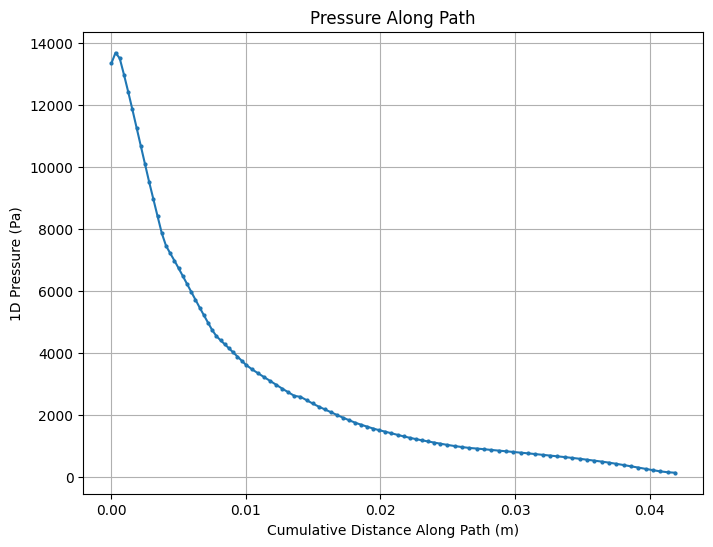

In [31]:
import Visualizer
importlib.reload(Visualizer)
Visualizer.plot_path_pressure(VTEST.uh1d, TEST_GRAPH, [0, 1, 3, 7])

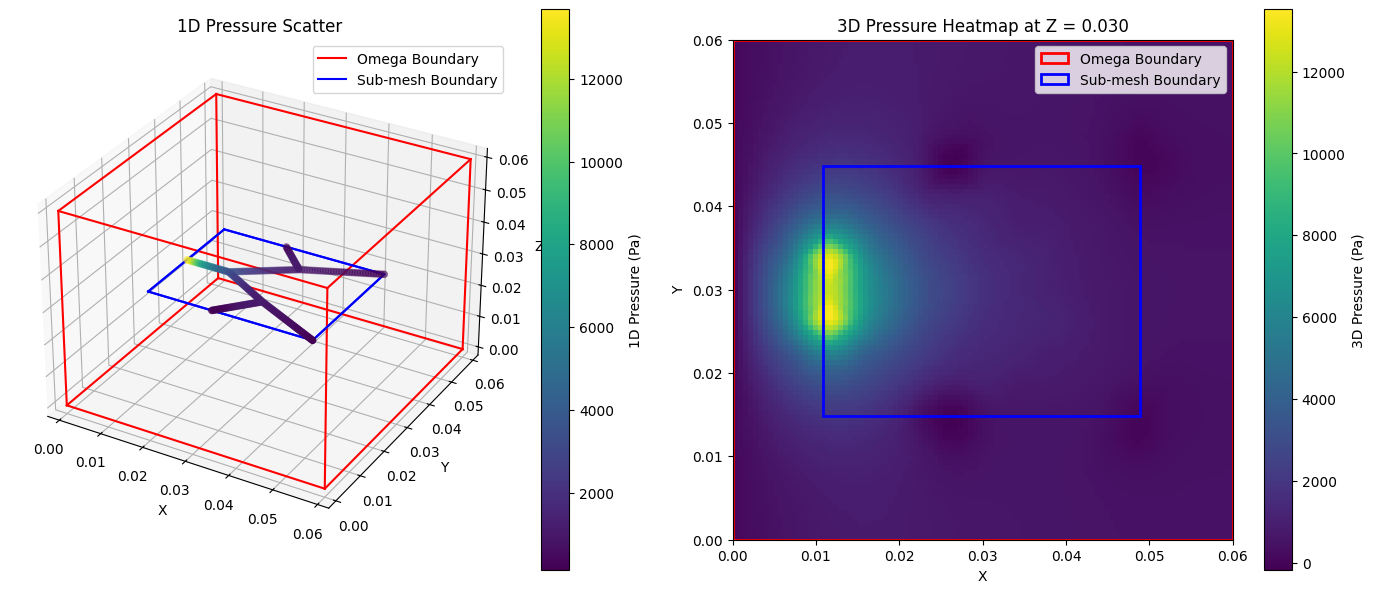

In [32]:
importlib.reload(Visualizer)

Visualizer.plot_with_boundaries(VTEST.uh1d, VTEST.uh3d)

In [34]:
import FEMSinkCubeFlux
import numpy as np
importlib.reload(FEMSinkCubeFlux)

TEST_GRAPH_CALIB = TEST_MESH.G_ref

CUBE_TEST = FEMSinkCubeFlux.FEMSinkCubeFlux(
    mc = TEST_MESH,
    gamma = 200,
    gamma_R = 8.0e-3,
    gamma_v = 2.0e-1,
    gamma_a = 1.0e-5,
    mu = 1.0e-3, # Viscosity
    k_t = 1.0e-10, # Tissue permeability in 3D
    k_v = 1.3e-11, # Vessel permeability in 1D
    P_in = 100.0 * 133.322, # 100 mmHg
    p_cvp = 1.0 * 133.322, # 1 mmHg
    Lambda_inlet = [0],
    Omega_sink = FACE_XZERO,
    upper_cube_bounds = [np.array(TEST_GRAPH_CALIB.nodes[7]['pos']) - np.array([0.01, 0.01, 0.01]),
                         np.array(TEST_GRAPH_CALIB.nodes[7]['pos']) + np.array([0.01, 0.01, 0.01])],
    lower_cube_bounds = [[0,0,0],[0.02, 0.02, 0.02]]
)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2488.97it/s]


Applied BC! Non-empty list


Lower Cube Bounds: [[0, 0, 0], [0.02, 0.02, 0.02]]
Upper Cube Bounds: [array([0.03882667, 0.03478889, 0.02      ]), array([0.05882667, 0.05478889, 0.04      ])]


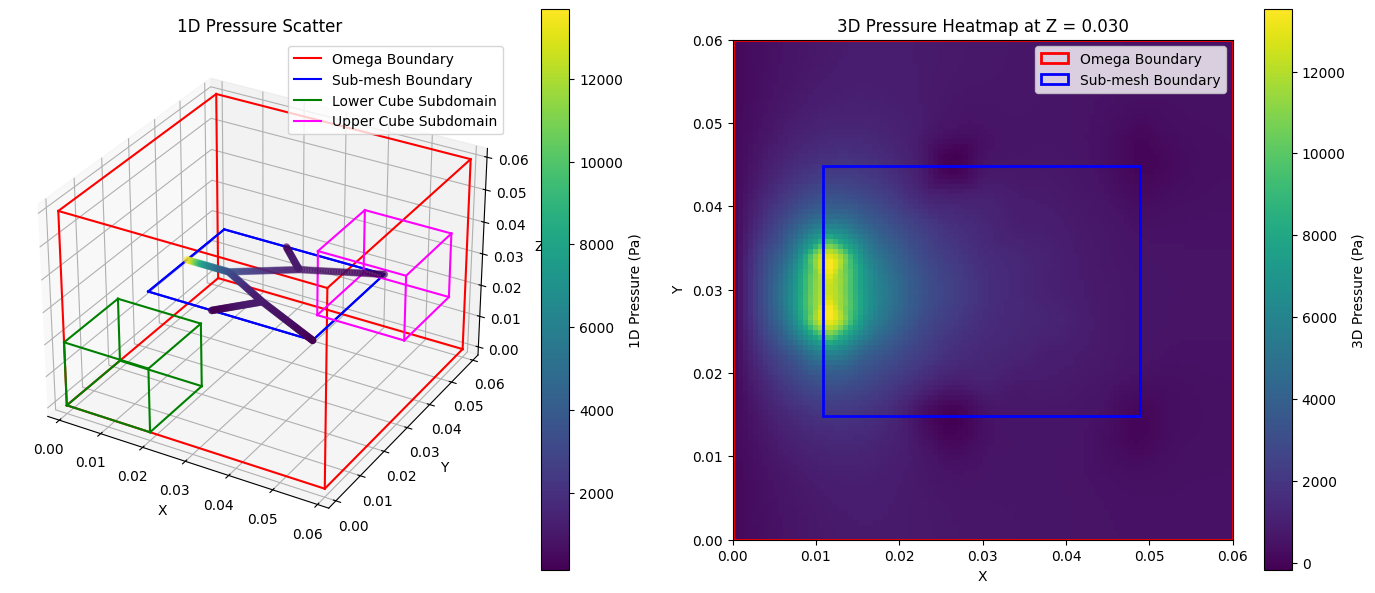

In [35]:
importlib.reload(Visualizer)
cube_lower_bounds = CUBE_TEST.lower_cube_bounds
cube_upper_bounds = CUBE_TEST.upper_cube_bounds

print("Lower Cube Bounds:", cube_lower_bounds)
print("Upper Cube Bounds:", cube_upper_bounds)

Visualizer.plot_with_boundaries(CUBE_TEST.uh1d, CUBE_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [45]:
print(CUBE_TEST.compute_lower_cube_flux())
print(CUBE_TEST.compute_upper_cube_flux())

4.2786104358829704e-07
1.5580589390093043e-05


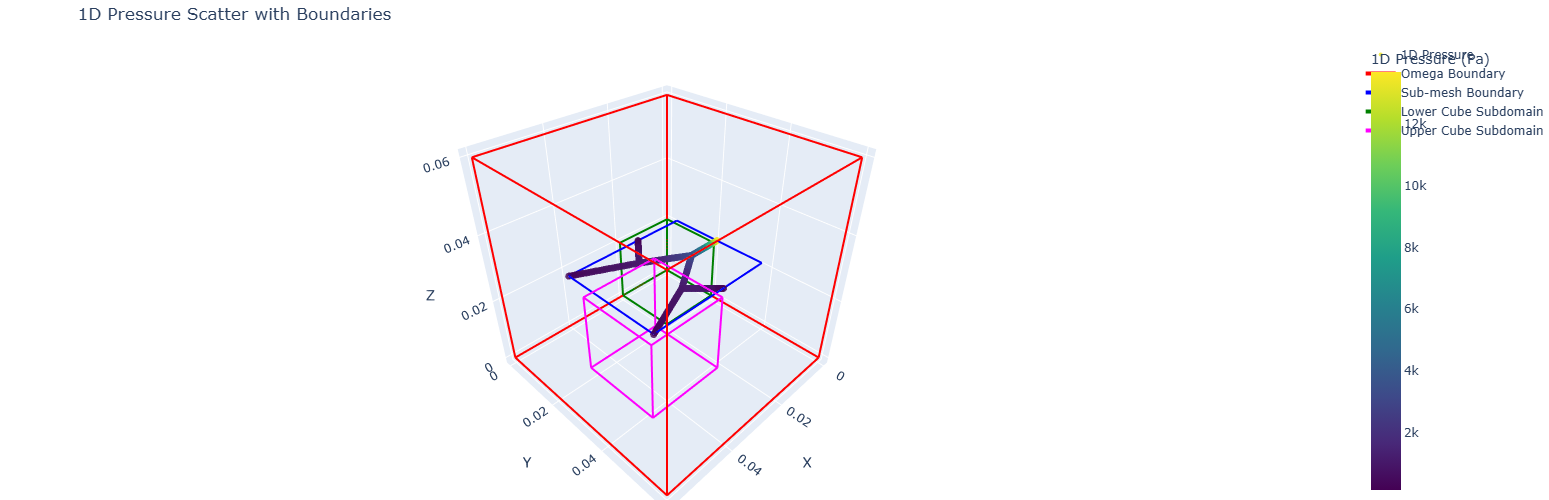

In [53]:
importlib.reload(Visualizer)
Visualizer.plot_with_boundaries_plotly(CUBE_TEST.uh1d, CUBE_TEST.uh3d,
     cube_lower=cube_lower_bounds, 
     cube_upper=cube_upper_bounds)

In [12]:
import datetime
import pytz

cst = pytz.timezone("America/Chicago")
now = datetime.datetime.now(cst)
timestamp = now.strftime("%Y%m%d_%H%M")
filename = f"output_{timestamp}"

SAVE_PATH = os.path.join(WORK_PATH, "export", filename)
CUBE_TEST.save_vtk(SAVE_PATH)

Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2924.42it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2096.87it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1929.97it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2053.78it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1966.62it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1997.97it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2006.85it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2020.72it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2028.25it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2005.09it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2032.37it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1954.89it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1957.93it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2016.59it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2156.89it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 2016.06it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1995.97it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1590.63it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1605.07it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1702.94it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1589.71it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1547.21it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1617.50it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1556.24it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1577.22it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1649.70it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1629.86it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1413.22it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1473.18it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1613.91it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1571.31it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1670.16it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1621.82it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1609.20it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1659.54it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1682.34it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1611.59it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1622.82it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1580.71it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1602.92it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1663.78it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1645.78it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1616.48it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1675.54it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1617.99it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1615.69it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1648.83it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1603.20it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1612.65it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1618.89it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1591.96it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1620.56it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1619.25it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1599.71it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1552.46it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1546.06it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1629.95it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1604.82it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1659.90it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1589.98it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1588.14it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1612.29it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1572.75it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1630.08it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1654.53it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1602.44it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1616.92it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1626.35it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1485.10it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1626.16it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1652.20it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1605.17it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1591.03it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1624.97it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1615.31it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1649.16it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1637.99it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1555.48it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1625.31it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1628.88it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1619.48it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1599.11it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1583.05it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1587.92it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1575.73it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1688.02it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1500.79it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1636.57it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1620.46it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1605.16it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1612.42it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1625.12it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1497.08it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1496.15it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1605.20it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1636.42it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1703.42it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1640.08it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1552.51it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1634.61it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1603.56it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1630.40it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1602.54it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1519.51it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1611.89it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1440.38it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1565.52it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1307.67it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1606.87it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1562.30it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1565.35it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1645.40it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1639.26it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1610.42it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1570.91it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1839.71it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1754.82it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1928.86it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1717.14it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1440.11it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1558.31it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1777.80it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1749.62it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1815.79it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1674.57it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1797.95it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1756.48it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1837.82it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1548.02it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1741.02it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1798.46it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1695.73it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1988.22it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1567.68it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1688.14it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1696.64it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1433.19it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1657.81it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1864.55it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1134.52it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1603.34it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1712.81it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1610.46it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1587.80it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1489.71it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1626.34it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1622.62it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1614.02it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1873.66it/s]


Applied BC! Non-empty list


Averaging over 224 cells: 100%|██████████| 224/224 [00:00<00:00, 1776.71it/s]


Applied BC! Non-empty list


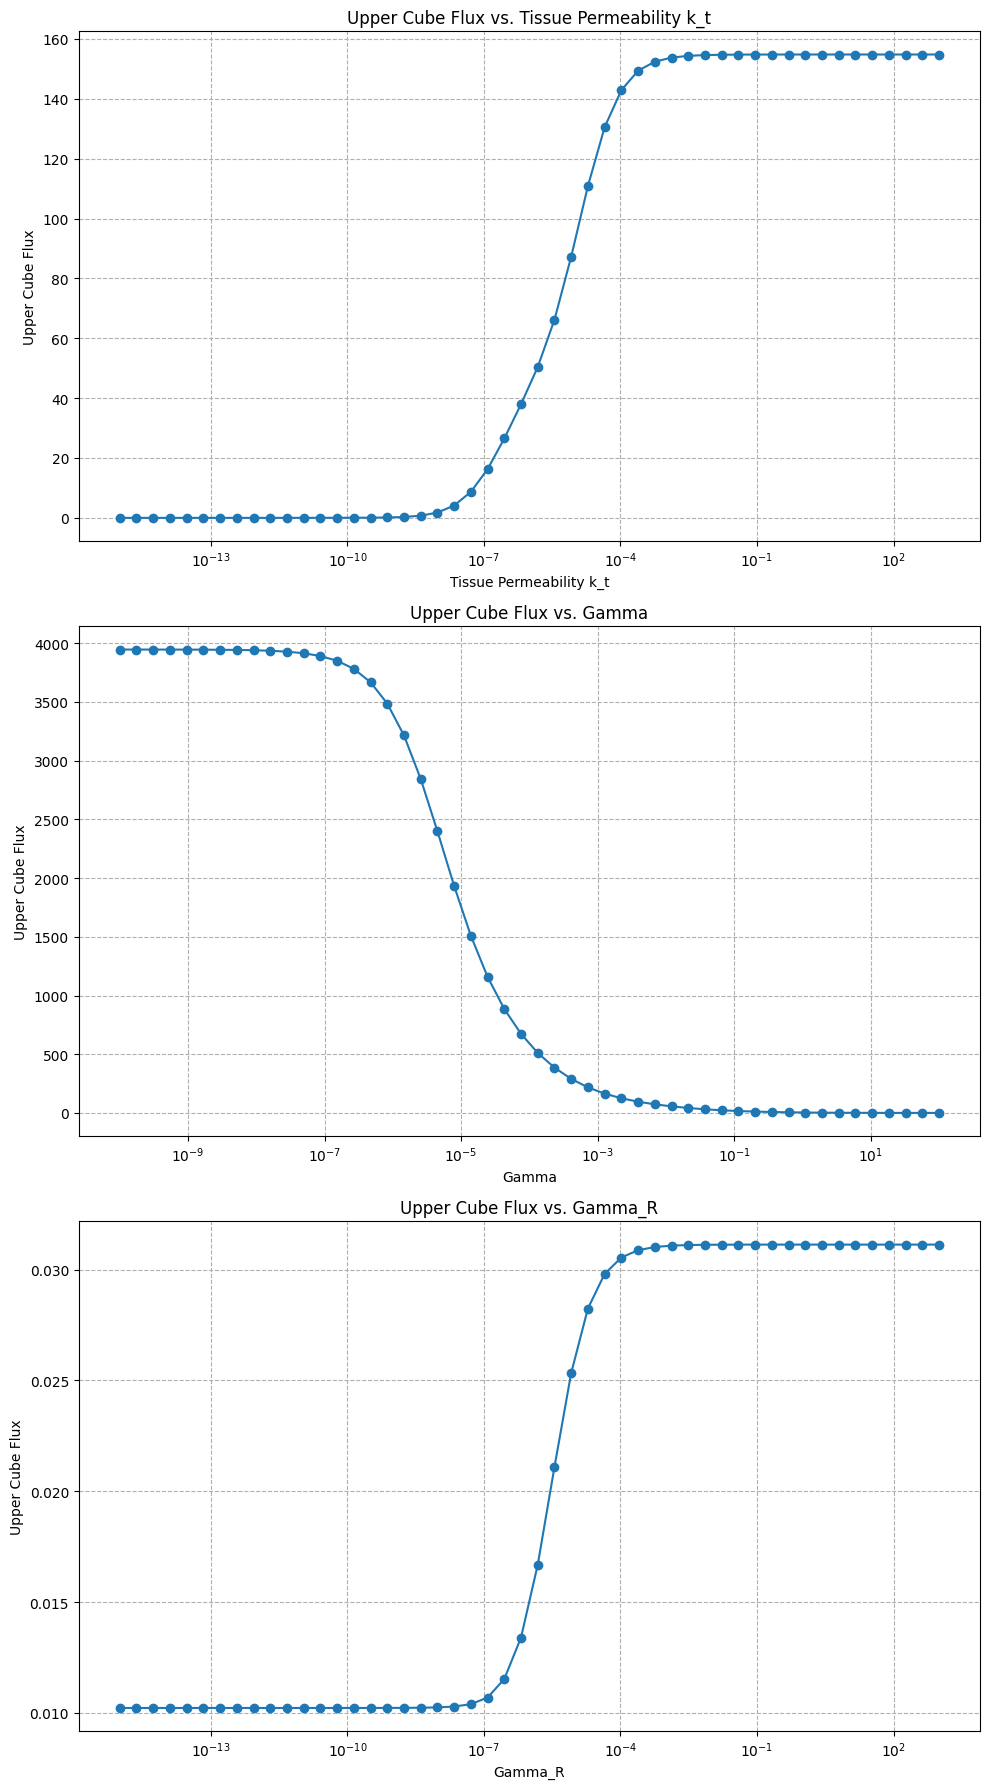

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import FEMSinkCubeFlux
import importlib
import time

importlib.reload(FEMSinkCubeFlux)

def run_sweep(param_name, values, defaults):
    fluxes = []
    for val in values:
        params = defaults.copy()
        params[param_name] = val
        cube_test = FEMSinkCubeFlux.FEMSinkCubeFlux(**params)
        flux = cube_test.compute_upper_cube_flux()
        fluxes.append(flux)
    return fluxes

def vary_parameters_and_plot(num_points=50, subset_plots = ['k_t', 'gamma', 'gamma_R']):   
    common_params = {
        'mc': TEST_MESH,
        'gamma': 200,            
        'gamma_R': 8.0e-3,      
        'gamma_v': 2.0e-1,
        'gamma_a': 450,
        'mu': 1.0e-3,
        'k_t': 1.0e-10,        
        'k_v': 7.6e-9,
        'P_in': 100.0 * 133.322,
        'p_cvp': 1.0 * 133.322,  
        'Lambda_inlet': [0],
        'Omega_sink': FACE_XZERO,
        'upper_cube_bounds': [
            np.array(TEST_GRAPH_CALIB.nodes[7]['pos']) - np.array([0.01, 0.01, 0.01]),
            np.array(TEST_GRAPH_CALIB.nodes[7]['pos']) + np.array([0.01, 0.01, 0.01])
        ],
        'lower_cube_bounds': [[0, 0, 0], [0.02, 0.02, 0.02]]
    }
    
    sweep_configs = {
        'k_t': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Tissue Permeability k_t",
            'title': "Upper Cube Flux vs. Tissue Permeability k_t",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma': {
            'values': np.logspace(-10, 2, num_points),
            'xlabel': "Gamma",
            'title': "Upper Cube Flux vs. Gamma",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        },
        'gamma_R': {
            'values': np.logspace(-15, 3, num_points),
            'xlabel': "Gamma_R",
            'title': "Upper Cube Flux vs. Gamma_R",
            'plot_type': 'semilogx',
            'grid_kwargs': {'which': "both", 'ls': "--"}
        }
    }
    
    num_plots = len(subset_plots)
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots))
    if num_plots == 1:
        axes = [axes]
    
    for idx, param in enumerate(subset_plots):
        config = sweep_configs[param]
        values = config['values']
        fluxes = run_sweep(param, values, common_params)
        
        if config['plot_type'] == 'semilogx':
            axes[idx].semilogx(values, fluxes, marker='o', linestyle='-')
        else:
            axes[idx].plot(values, fluxes, marker='o', linestyle='-')
        
        axes[idx].set_xlabel(config['xlabel'])
        axes[idx].set_ylabel("Upper Cube Flux")
        axes[idx].set_title(config['title'])
        axes[idx].grid(True, **config['grid_kwargs'])
    
    plt.tight_layout()
    plt.show()

vary_parameters_and_plot(num_points=50)